# Assignment 8: Moving Beyond Linearity

Dataset(s) needed:
Wage data frame of the ISLR library SF-DAT-21 (https://github.com/ga-students/sf-dat-21/tree/master/unit-projects/dataset)

Libraries needed:
stats
gam

In [ ]:
library("stats")
library("gam")
library("ISLR")
library("splines")
library("magrittr")
library("tidyverse")

data(Wage)
str(Wage)
head(Wage)

summarizeNA <- function(df)
    {
        df <- df[sapply(df, function(x) sum(is.na(x)) > 0)] # show ONLY features with NA's
        
        result <- data.frame(na.count = sapply(df, function(x) length(x[is.na(x)])),
                    na.freq = sapply(df, function(x) length(x[is.na(x)])/length(x)),
                    feature.class = sapply(df, function(x) ifelse(is.factor(x), "factor", "num")))
        result$subcategories <- sapply(X = rownames(result), function(x) unique(house[, colnames(house) == x]))
        return(result)
    }

summarizeNA(Wage)

## Q1. Using the wage data, find polynomial fit for wage depending on age. Select the best value for the degree.


,i,RMSE
4,4,40.4734


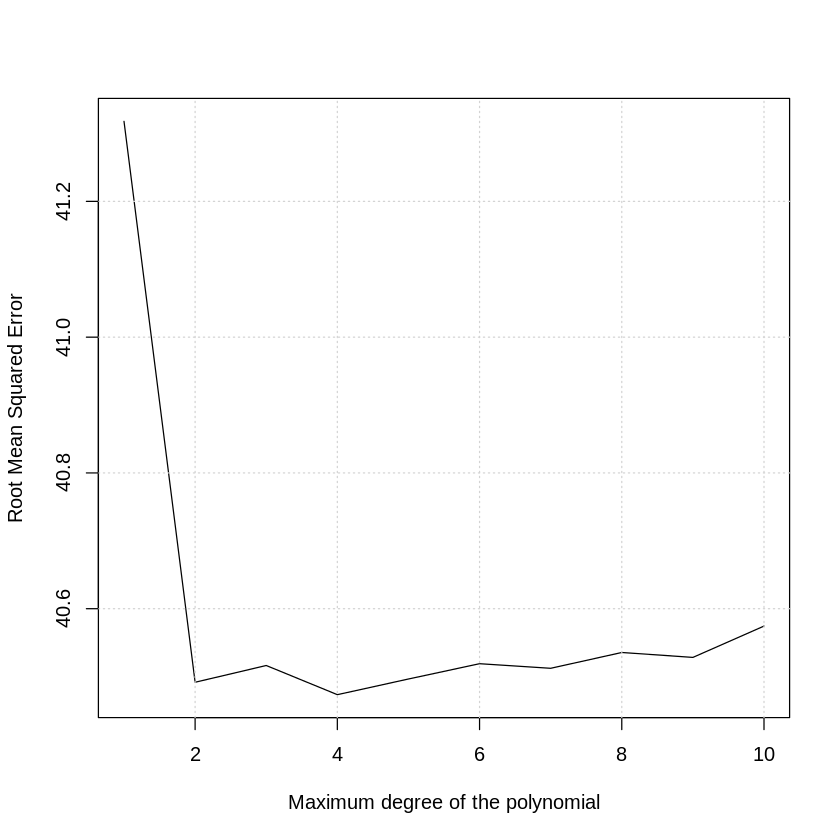

In [9]:
##### split data into train/test sets
set.seed(223)
idx <- sample(x = 2, replace = TRUE, size = nrow(Wage), prob = (c(0.7, 0.3)))
Wage_train <- Wage[idx==1,]
Wage_test <- Wage[idx==2,]
# dim(Wage)
# dim(Wage_train)
# dim(Wage_test)

##### fit polynomial regression (up to 20th degree) on train set
lm_rmse <- data.frame()
for(i in 1:10)
    {
        lm_mod <- lm(wage~poly(age,i), data = Wage_train)
        lm_pred <- predict(lm_mod, Wage_test)
        lm_rmse <- rbind(lm_rmse, data.frame('i' = i, "RMSE" = sqrt(mean((Wage_test$wage - lm_pred)^2))))
    }

# Higest degree polynomial with lowest RMSE
lm_rmse[which.min(lm_rmse$RMSE),]

# plot
with(lm_rmse, plot(RMSE~i, type="l", 
                xlab="Maximum degree of the polynomial", 
                ylab="Root Mean Squared Error"))
grid()

> __ANSWER Q1:__  
The 4th degree polynomial gives the best fit.

## Q2. Using the wage data, construct a generalized additive model and compare to linear regression. 


method,RMSE
lm,40.47340
gam,40.48947


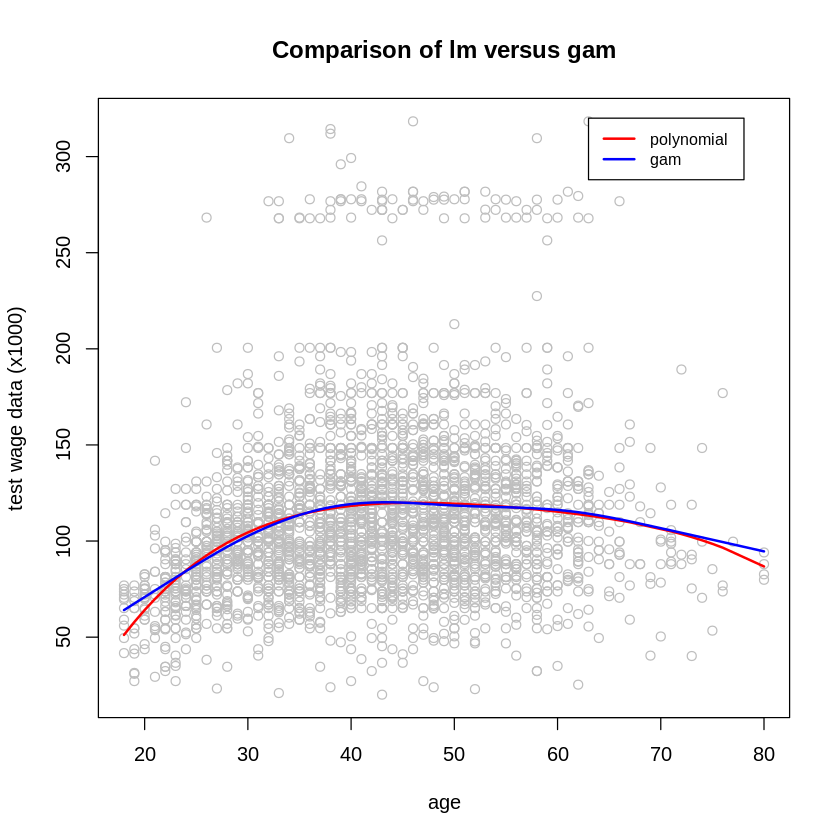

In [10]:
##### predicting wage using GAM
gam_mod <- gam(wage ~ s(age), data = Wage_train)
gam_pred <- predict(gam_mod, Wage_test)
gam_rmse  <- sqrt(mean((Wage_test$wage - gam_pred)^2))

#### predicting wage using 4th degree polynomial
lm_mod2 <- lm(wage~poly(x = age, degree = 4), data = Wage_train)
lm_pred2 <- predict(lm_mod2, Wage_test)
lm_rmse2 <- sqrt(mean((Wage_test$wage - lm_pred2)^2))

data.frame("method"=c("lm", "gam"), "RMSE"=c(lm_rmse2, gam_rmse))

df <- data.frame("age" = Wage_test$age, "obs" = Wage_test$wage,"lm"=lm_pred2, "gam"=gam_pred)  %>% dplyr::arrange(.,age)

plot(x = Wage$age, y = Wage$wage, col = "gray",
     xlab = "age", ylab="test wage data (x1000)", main="Comparison of lm versus gam")
lines(formula = lm ~ age, col = "red", lwd=2,data = df)
lines(formula = gam ~ age, col = "blue", lwd=2,data = df)
legend(x=63, y=320, legend=c("polynomial", "gam"), col=c("red", "blue"), lty=c(1,1), lwd=c(2,2), cex=0.8)


> __ANSWER Q2:__  
The 4th degree polynomial and gam predictions on the test data are remarkably similar. Both methods have RMSE=40.5 on the test data set.

## Q3. Using the wage data, Create a smooth-spline model, having CV select the value of smoothing parameter and degrees of freedom.

Warning message in smooth.spline(x = Wage_train$age, y = Wage_train$wage, cv = TRUE):
“cross-validation with non-unique 'x' values seems doubtful”

[1] 6.951226

[1] 0.01741592

[1] 40.49608

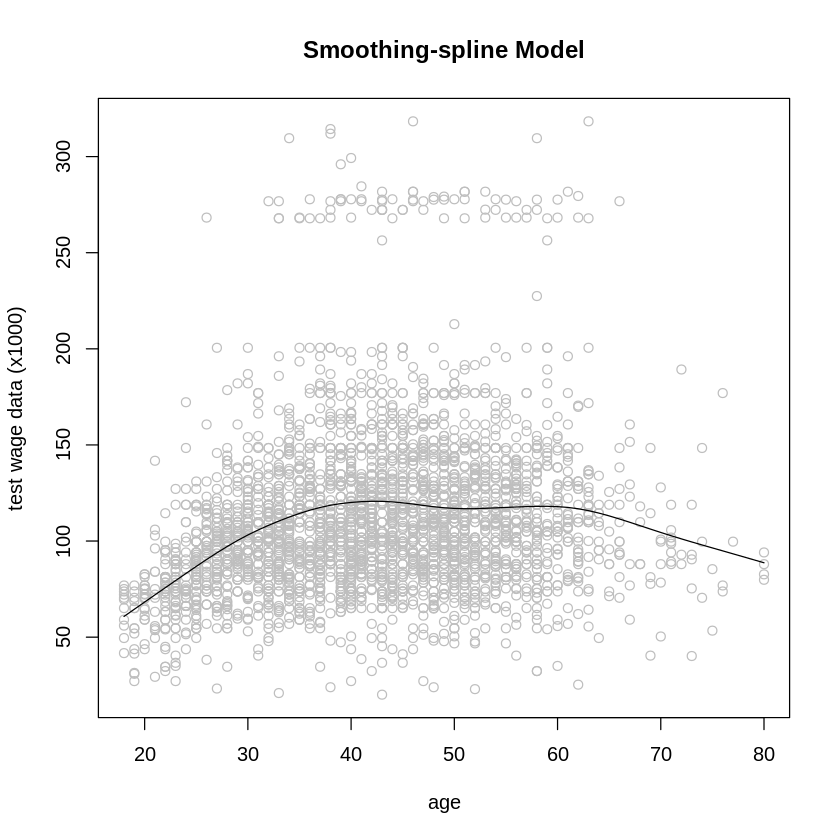

In [11]:
##### training: fit wage versus age using training data
ss_mod <- smooth.spline(x = Wage_train$age, y = Wage_train$wage, cv=TRUE)
ss_mod$df
ss_mod$lambda

##### get test RMSE
ss_pred <- predict(object = ss_mod, x = Wage_test$age)
ss_rmse <- sqrt(mean((Wage_test$wage - ss_pred$y)^2))
ss_rmse

plot(x = Wage$age, y = Wage$wage, col = "gray",
     xlab = "age", ylab="test wage data (x1000)", main="Smoothing-spline Model")
lines(ss_mod) # fitted values on train data

# lines(formula = wage ~ age, lwd=2, col = "green",
#       data = data.frame("age"=ss_pred$x, "wage"=ss_pred$y) %>% dplyr::arrange(., age))  # predicted values on test set
# legend(x=63, y=320, legend=c("train", "test"), col=c("black", "green"), lty=c(1,1), lwd=c(2,2), cex=0.8)

> __ANSWER Q3__  
> By setting `cv=TRUE` in `smooth.pline()`, the function returns the LOOCV-cross-validated "optimal" values of smoothing parameter of $\lambda = 0.02$ and $df = 6.95$. The test RMSE of 40.5 is virtually identical to that obtained by lm and gam method in Q2. Perhaps I did something wrong???

## Q4. Using the admissions data, predict grad school acceptance using regression splines.

In [12]:
admissions <- read.csv("https://github.com/ga-students/sf-dat-21/raw/master/unit-projects/dataset/admissions.csv")
# str(admissions)

##### divide into train/test
set.seed(87)
idx <- sample(x = c(1,2), size = nrow(admissions), replace = TRUE, prob = c(0.8, 0.2))
admit_train <- admissions[idx == 1,]
admit_test <- admissions[idx == 2,]

##### using ordinary linear regression in GAM to fit all 3 predictors
admit_mod <- gam(I(admit==1) ~ ns(gre) + ns(gpa) + ns(prestige), family = binomial, data = admit_train)
admit_pred <- predict(admit_mod, admit_test[,2:4], type="response")
# admit_mod$coefficients

##### confusion matrix from prediction
actual <- ifelse(admit_test$admit == 1, 'Y', 'N')
predicted <- ifelse(admit_pred > 0.5, 'Y', 'N')
table(predicted,actual)

         actual
predicted  N  Y
        N 47 21
        Y  6  6

> __ANSWER Q4:__  
> I used natural splines on all 3 variables to generate a GAM-based model on the training set. The model is    
> 
$$E(admit|gre,gpa,prestige)=-1.87+2.07{\cdot}gre+1.61{\cdot}gpa-2.33{\cdot}prestige$$  
> (I did NOT cross-validate the model since the question didn't ask to do it). I then used the model to predict grad school admissions, using the test set. The model accuracy is about 66%

## Q5. Using your admissions data model, what is the effect of going from 3.0 GPA to 4.0 GPA on the odds of admission?

> __ANSWER Q5:__  
> Let $\frac{p(X)}{1-p(X)}$ equal the odds of being admitted with a 3.0 GPA. Then,    
 
>log(odds) of being admitted with 3.0 GPA:  $log\left[\frac{p(X)}{1-p(X)}\right]=-1.87+2.07{\cdot}gre+1.61X-2.33{\cdot}prestige$  

> log(odds) of being admitted with 4.0 GPA: $log\left[\frac{p(X+1)}{1-p(X+1)}\right]=-1.87+2.07{\cdot}gre+1.61(X+1)-2.33{\cdot}prestige$  
> difference log odds: $$log\left[\frac{p(X+1)}{1-p(X+1)}\right]-log\left[\frac{p(X)}{1-p(X)}\right]= log\left[\frac{\frac{p(X+1)}{1-p(X+1)}}{\frac{p(X)}{1-p(X)}}\right] =1.61$$  
> odds ratio:  
$$\frac{\frac{p(X+1)}{1-p(X+1)}}{\frac{p(X)}{1-p(X)}}=e^{1.61}\approx5.0$$
>
> Therefore, in going from a 3.0 to 4.0 GPA, the model predicts a 5-fold increase in the odds of getting admitted, all else being equal.